### Refined Code to Collect BTC Options Data + Derive Implied Volatilities + Plot Volatility Surfaces - Christos Stamatelopoulos 30/05/24

In [1]:
import requests
from datetime import datetime ### MANIPULATION OF TIME VALUES, HUMAN-READABLE TO UNIX AND VICE VERSA
import pandas as pd

### SUB=FUNCTION [1] TO REQUEST BTC OPTIONS DATA (DERIBIT API)
### THE DATA WE ARE LOOKING FOR DO NOT REQUIRE AN API KEY/SECRET 
def fetch_deribit_options(): 
    url = 'https://www.deribit.com/api/v2/public/get_instruments?currency=BTC&kind=option'
    response = requests.get(url, timeout=10) #TIME-OUT IS INTRODUCED TO PERFORM A GENTLE REQUEST TO THE API
    response.raise_for_status()
    options = response.json()['result']
    return options

### SUB-FUNCTION [2] TO REQUEST BTC DATA (DERIBIT API)
### THE UNDERLYING ASSET IS THE BTC-PERPETUAL-FUTURES-CONTRACT (NOT THE BITCOIN SPOT)
### I HAVE DESCRIBED BTC-PERPETUAL AS A SPOT-MARKET CLONE (THE MAIN DIFFERENCE IS THE FUNDING RATE THAT AIMS TO CORRECT ARBITRAGE OPPORTUNITIES)
### THIS IS SEQUENTIALLY NEEDED TO COLLECT OPTION PRICES AND THE UNDERLYING ASSET PRICE AT THE SAME EXACT TIME (i.e. a snapshot of the market)
def fetch_btc_spot_price():
    url = 'https://www.deribit.com/api/v2/public/ticker?instrument_name=BTC-PERPETUAL'
    response = requests.get(url, timeout=10) #TIME-OUT IS INTRODUCED TO PERFORM A GENTLE REQUEST TO THE API
    response.raise_for_status()
    spot_price = response.json()['result']['last_price']
    return spot_price

### SUB-FUNCTION [3] TO REQUEST BTC OPTIONS DATA (DERIBIT API)
def fetch_option_market_data(instrument_name):
    url = f'https://www.deribit.com/api/v2/public/ticker?instrument_name={instrument_name}'
    response = requests.get(url, timeout=10) #TIME-OUT IS INTRODUCED TO PERFORM A GENTLE REQUEST TO THE API
    response.raise_for_status()
    return response.json()['result']

### ULTIMATE DATA COLLECTION FUNCTION
def main():
    try:
        print("Fetching options data...")
        options_data = fetch_deribit_options()
        print(f"Fetched {len(options_data)} options.")

        print("Fetching spot price...")
        spot_price = fetch_btc_spot_price()
        print(f"Spot price: {spot_price}")

        results = []

        for option in options_data:
            try:
                print(f"Processing option: {option['instrument_name']}")
                market_data = fetch_option_market_data(option['instrument_name'])
                market_price_btc = market_data['mark_price']  ### MARKET PRICE OF THE OPTION IN BTC
                market_price_usdt = market_price_btc * spot_price ### MANUAL CONVERSION TO USD TERMS FOR BLACK=SCHOLES FRAMEWORK
                strike_price = option['strike']
                expiration_timestamp = option['expiration_timestamp'] / 1000
                time_to_maturity = (datetime.fromtimestamp(expiration_timestamp) - datetime.now()).days / 365.0 ### LET'S BE DONE WITH "T" ALREADY

                result = {
                    'Instrument Name': option['instrument_name'],
                    'Strike': strike_price,
                    'Maturity': datetime.fromtimestamp(expiration_timestamp).strftime('%Y-%m-%d'),
                    'Market Price (BTC)': market_price_btc,
                    'Market Price in USDT': market_price_usdt,
                    'Type': option['option_type'],
                    'Spot Price (BTC)': spot_price,
                    'Time to Maturity (Years)': time_to_maturity
                }
                results.append(result)
            except Exception as e:
                print(f"Error processing option {option['instrument_name']}: {e}")

        ### RESULTS TO DATAFRAME
        df = pd.DataFrame(results)
        
        ### DATAFRAME TO EXCEL
        df.to_excel('deribit_bitcoin_options3005.xlsx', index=False) ### NAME THE LAST 4 DIGITS TO REFLECT THE CURRENT DATE
        print("Data saved to deribit_bitcoin_options3005.xlsx , gottem good")

    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == '__main__':
    main()

Fetching options data...
Fetched 1048 options.
Fetching spot price...
Spot price: 69477.0
Processing option: BTC-31MAY24-20000-C
Processing option: BTC-31MAY24-20000-P
Processing option: BTC-31MAY24-25000-C
Processing option: BTC-31MAY24-25000-P
Processing option: BTC-31MAY24-30000-C
Processing option: BTC-31MAY24-30000-P
Processing option: BTC-31MAY24-35000-C
Processing option: BTC-31MAY24-35000-P
Processing option: BTC-31MAY24-38000-C
Processing option: BTC-31MAY24-38000-P
Processing option: BTC-31MAY24-40000-C
Processing option: BTC-31MAY24-40000-P
Processing option: BTC-31MAY24-42000-C
Processing option: BTC-31MAY24-42000-P
Processing option: BTC-31MAY24-44000-C
Processing option: BTC-31MAY24-44000-P
Processing option: BTC-31MAY24-45000-C
Processing option: BTC-31MAY24-45000-P
Processing option: BTC-31MAY24-46000-C
Processing option: BTC-31MAY24-46000-P
Processing option: BTC-31MAY24-47000-C
Processing option: BTC-31MAY24-47000-P
Processing option: BTC-31MAY24-48000-C
Processing op

In [2]:
### A MANUAL CHECK IS ENOUGH TO SEE THE FOLLOWING:
### THE CODE FAILS TO CALCULATE 'T' FOR OPTIONS EXPIRING TOMORROW BECAUSE 'T' IS PERHAPS CONSIDERED VERY SMALL
### SOME OPTIONS ARE PRICED AS ZERO: THAT HAPPENS BECAUSE THE ASK_PRICE HAS NOT BE COVERED BY BID_PRICE
## TAKING THE AVERAGE OF ASK+BID TO CONSIDER AS MARKET PRICE I CONSIDERED AS FALSE BECAUSE SINCE THE OPTION IS NOT PRICED YET
# THEN THE VALUES COULD BE IRRELEVANT AND SKEW THE DATA ERRONEOUSLY, HENCE I WILL DELETE ALL OPTIONS PRICED AS ZERO 
# BECAUSE MY GOAL HERE IS TO COMPUTE THE IMPLIED VOLATILITIES
### THE ABOVE 2 PROBLEMS WILL NOW BE FIXED

In [3]:
df = pd.read_excel('deribit_bitcoin_options3005.xlsx')

### COUNT HOW MANY OPTIONS ARE PRICED AS ZERO 
zero_count = (df['Market Price in USDT'] == 0).sum()
total_count = df['Market Price in USDT'].count()
print(f"{zero_count} out of {total_count} options not priced yet.")

### DELETING OPTIONS PRICED AS ZERO
df = df[df['Market Price in USDT'] != 0]
print(f"Those options have now been deleted from our dataset.")

### MANUAL FIX FOR 'T' ONLY FOR THOSE OPTIONS EXPIRING TOMORROW WHICH PYTHON YIELDED AS ZERO
replacement_value = 0.00273972602739726027397260273973
df['Time to Maturity (Years)'] = df['Time to Maturity (Years)'].replace(0, replacement_value)

### SAVE THE NEW EXCEL
df.to_excel('deribit_bitcoin_options3005.xlsx', index=False)

60 out of 1048 options not priced yet.
Those options have now been deleted from our dataset.


In [4]:
options_data = pd.read_excel("deribit_bitcoin_options3005.xlsx")
options_data.head()

,Instrument Name,Strike,Maturity,Market Price (BTC),Market Price in USDT,Type,Spot Price (BTC),Time to Maturity (Years)
0,BTC-31MAY24-20000-C,20000,2024-05-31,0.7122,49481.5194,call,69477,0.00274
1,BTC-31MAY24-25000-C,25000,2024-05-31,0.6402,44479.1754,call,69477,0.00274
2,BTC-31MAY24-30000-C,30000,2024-05-31,0.5683,39483.7791,call,69477,0.00274
3,BTC-31MAY24-35000-C,35000,2024-05-31,0.4963,34481.4351,call,69477,0.00274
4,BTC-31MAY24-38000-C,38000,2024-05-31,0.4532,31486.9764,call,69477,0.00274


In [5]:
### EXTRACTING ONLY WHAT BLACK-SCHOLES NEEDS
strike_prices = options_data['Strike']
maturities = options_data['Time to Maturity (Years)']
market_prices = options_data['Market Price in USDT']
option_types = options_data['Type']
spot_prices = options_data['Spot Price (BTC)'].unique()[0]

import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

### BLACK-SCHOLES FORMULA FOR CALL OPTIONS
def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

### BLACK-SCHOLES FORMULA FOR PUT OPTIONS
def bs_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

### DEFINING THE IMPLIED VOLATILITY FUNCTION USING BRENT'S METHOD
def implied_volatility(option_price, S, K, T, r, option_type='call'):
    if option_type == 'call':
        objective_function = lambda sigma: bs_call(S, K, T, r, sigma) - option_price
    elif option_type == 'put':
        objective_function = lambda sigma: bs_put(S, K, T, r, sigma) - option_price
    else:
        raise ValueError("Option type must be 'call' or 'put'")
    
    try:
        implied_vol = brentq(objective_function, 1e-6, 5)
        return implied_vol
    except Exception as e:
        return np.nan

### RISK-FREE RATE IS DEBATABLE
### LIBOR IS BEING PHASED OUT
### OUR OPTIONS HAVE 'T' RANGING FROM 0 TO 0.82 SO I AM THINKING ABOUT U.S. 1-YEAR TREASURY YIELDS AND SOFR
### I WILL USE THE CURRENT DATE U.S. 1-YEAR TREASURY YIELD RATE BEING 5.21%
risk_free_rate = 0.0521

### CALCULATING THE IMPLIED VOLATILITY FOR EACH OPTION
implied_vols = []
for i in range(len(options_data)):
    S = spot_prices
    K = strike_prices[i]
    T = maturities[i]
    option_price = market_prices[i]
    option_type = option_types[i]
    iv = implied_volatility(option_price, S, K, T, risk_free_rate, option_type)
    implied_vols.append(iv)

### ADD IMPLIED VOLATILITIES TO THE DATA FRAME
options_data['Implied Volatility'] = implied_vols
options_data

,Instrument Name,Strike,Maturity,Market Price (BTC),Market Price in USDT,Type,Spot Price (BTC),Time to Maturity (Years),Implied Volatility
0,BTC-31MAY24-20000-C,20000,2024-05-31,0.7122,49481.5194,call,69477,0.002740,NaN
1,BTC-31MAY24-25000-C,25000,2024-05-31,0.6402,44479.1754,call,69477,0.002740,NaN
2,BTC-31MAY24-30000-C,30000,2024-05-31,0.5683,39483.7791,call,69477,0.002740,NaN
3,BTC-31MAY24-35000-C,35000,2024-05-31,0.4963,34481.4351,call,69477,0.002740,NaN
4,BTC-31MAY24-38000-C,38000,2024-05-31,0.4532,31486.9764,call,69477,0.002740,3.892962
...,...,...,...,...,...,...,...,...,...
983,BTC-28MAR25-220000-P,220000,2025-03-28,1.8852,130978.0404,put,69477,0.824658,NaN
984,BTC-28MAR25-250000-C,250000,2025-03-28,0.0228,1584.0756,call,69477,0.824658,0.796722
985,BTC-28MAR25-250000-P,250000,2025-03-28,2.2663,157455.7251,put,69477,0.824658,NaN
986,BTC-28MAR25-300000-C,300000,2025-03-28,0.0145,1007.4165,call,69477,0.824658,0.810009


In [6]:
## COUNT HOW MANY IMPLIED VOLATILITIES GOT SPITTED OUT AS NaN
zero_count_2 = (options_data['Implied Volatility'] == 0).sum()
NaN_count = options_data['Implied Volatility'].isnull().sum()
total_count_2 = options_data['Instrument Name'].count()
print(f"Out of {total_count_2} options {zero_count_2} IVs are spitted out as 0 and {NaN_count} IVs are spitted out as NaN.")

Out of 988 options 0 IVs are spitted out as 0 and 122 IVs are spitted out as NaN.


In [7]:
### DETECT WHETHER THEY ARE COMING FROM CALLS OR PUTS
nan_iv = options_data[options_data['Implied Volatility'].isnull()]
call_count = (nan_iv['Type'] == 'call').sum()
put_count = (nan_iv['Type'] == 'put').sum()
print(f"There are {call_count} 'call' options and {put_count} 'put' options with 'NaN' in the 'Implied Volatility' column.")

There are 4 'call' options and 118 'put' options with 'NaN' in the 'Implied Volatility' column.


In [8]:
### IMPORTANT PERSONAL ACKNOWLEDGMENTS AND CONCLUSIONS HERE WHILST DERIVING THE IMPLIED VOLATILITY:
### NEWTON-RAPHSON METHOD PERFORMS THE WORST 
### BRENT'S METHOD (THE ONE BEING USED HERE) AND BISECTION METHOD PERFORM EQUALLY WELL
### IT IS NOT EASY TO COMPUTE THE NaN IMPLIED VOLATILITIES 
### I HAVE TESTED A FOURTH METHOD, THE BINOMIAL APPROACH AND MANAGED TO COMPUTE SOME OF THE NaN VALUES
### ALL OF THESE VALUES SEEM TO BE BELOW 0.2% (i.e. 0.0002) VOLATILITY !!!
### HOWEVER, TO MAINTAIN THIS CODE'S HEALTH I WILL BE DELETING NaN IVs FOR THE TIME BEING

In [9]:
options_data.dropna(subset=['Implied Volatility'], inplace=True)
options_data.to_excel('deribit_bitcoin_options3005.xlsx', index=False) ### NAME THE LAST 4 DIGITS TO REFLECT THE CURRENT DATE
options_data ### Referencing stays the same

,Instrument Name,Strike,Maturity,Market Price (BTC),Market Price in USDT,Type,Spot Price (BTC),Time to Maturity (Years),Implied Volatility
4,BTC-31MAY24-38000-C,38000,2024-05-31,0.4532,31486.9764,call,69477,0.002740,3.892962
5,BTC-31MAY24-40000-C,40000,2024-05-31,0.4244,29486.0388,call,69477,0.002740,3.485753
6,BTC-31MAY24-42000-C,42000,2024-05-31,0.3956,27485.1012,call,69477,0.002740,3.076676
7,BTC-31MAY24-44000-C,44000,2024-05-31,0.3668,25484.1636,call,69477,0.002740,2.626913
8,BTC-31MAY24-45000-C,45000,2024-05-31,0.3525,24490.6425,call,69477,0.002740,2.991015
...,...,...,...,...,...,...,...,...,...
978,BTC-28MAR25-180000-C,180000,2025-03-28,0.0488,3390.4776,call,69477,0.824658,0.773095
980,BTC-28MAR25-200000-C,200000,2025-03-28,0.0382,2654.0214,call,69477,0.824658,0.778906
982,BTC-28MAR25-220000-C,220000,2025-03-28,0.0308,2139.8916,call,69477,0.824658,0.786745
984,BTC-28MAR25-250000-C,250000,2025-03-28,0.0228,1584.0756,call,69477,0.824658,0.796722


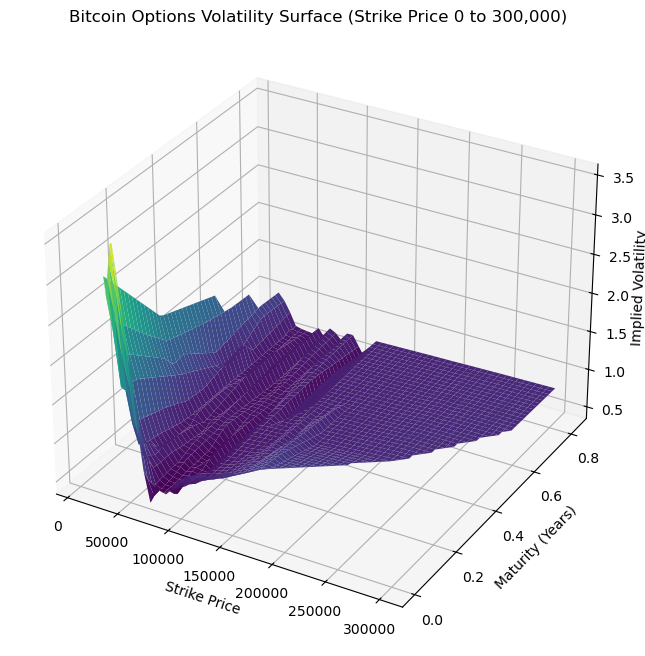

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

### COLUMNS FOR THE VOLATILITY SURFACE
strike_prices = options_data['Strike']
maturities = options_data['Time to Maturity (Years)']
implied_vols = options_data['Implied Volatility']

### CREATING A GRID FOR STRIKES AND MATURITIES
strike_grid = np.linspace(strike_prices.min(), strike_prices.max(), 50)
maturity_grid = np.linspace(maturities.min(), maturities.max(), 50)
strike_grid, maturity_grid = np.meshgrid(strike_grid, maturity_grid)

### INTERPOLATING IMPLIED VOLATILITIES
vol_surface = griddata(
    (strike_prices, maturities),
    implied_vols,
    (strike_grid, maturity_grid),
    method='linear'  # Changed to 'linear'
)

### PLOTTING THE VOLATILITY SURFACE
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(strike_grid, maturity_grid, vol_surface, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Maturity (Years)')
ax.set_zlabel('Implied Volatility', labelpad = 0)
ax.set_title('Bitcoin Options Volatility Surface (Strike Price 0 to 300,000)')

### Use the following code to adjust the viewing angle depending on results
### ax.view_init(elev=10, azim=60) ### Play with the numbers

plt.show()

In [11]:
### HERE THE THING IS THAT THE VOLATILITY SURFACE INCLUDES BOTH CALLS AND PUTS
### I WILL PLOT TWO SEPERATE FIGURES, ONE FOR CALLS AND ONE FOR PUTS 

In [12]:
options_data_copy = options_data.copy()
options_data_calls = options_data_copy[options_data_copy['Type'] != 'put']
options_data_puts = options_data_copy[options_data_copy['Type'] != 'call']

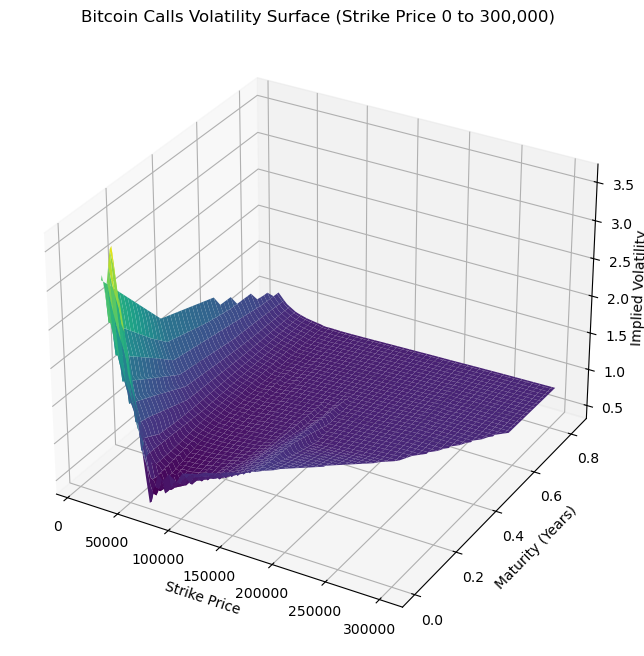

In [29]:
### COLUMNS FOR THE VOLATILITY SURFACE
strike_prices = options_data_calls['Strike']
maturities = options_data_calls['Time to Maturity (Years)']
implied_vols = options_data_calls['Implied Volatility']

### CREATING A GRID FOR STRIKES AND MATURITIES
strike_grid = np.linspace(strike_prices.min(), strike_prices.max(), 100)
maturity_grid = np.linspace(maturities.min(), maturities.max(), 100)
strike_grid, maturity_grid = np.meshgrid(strike_grid, maturity_grid)

### INTERPOLATING IMPLIED VOLATILITIES
vol_surface = griddata(
    (strike_prices, maturities),
    implied_vols,
    (strike_grid, maturity_grid),
    method='linear'  # Changed to 'linear'
)

### PLOTTING THE VOLATILITY SURFACE
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(strike_grid, maturity_grid, vol_surface, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Maturity (Years)')
ax.set_zlabel('Implied Volatility', labelpad = 0)
ax.set_title('Bitcoin Calls Volatility Surface (Strike Price 0 to 300,000)')

### Use the following code to adjust the viewing angle depending on results
### ax.view_init(elev=10, azim=60) ### Play with the numbers

plt.show()

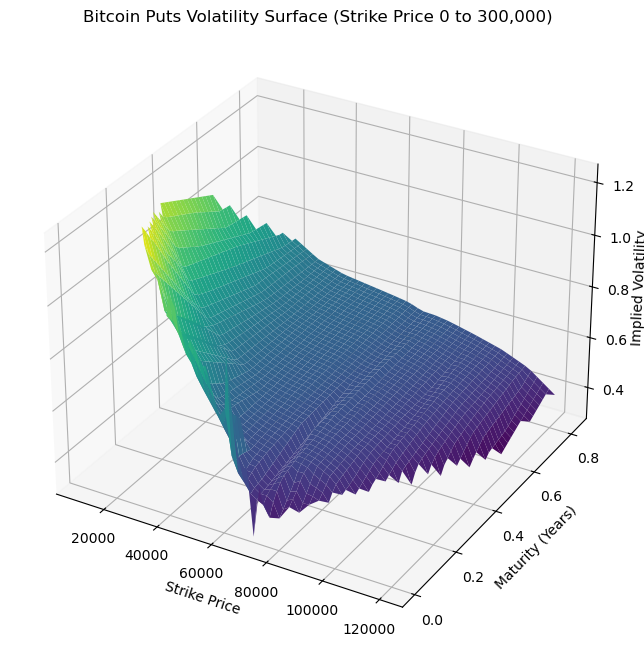

In [23]:
### COLUMNS FOR THE VOLATILITY SURFACE
strike_prices = options_data_puts['Strike']
maturities = options_data_puts['Time to Maturity (Years)']
implied_vols = options_data_puts['Implied Volatility']

### CREATING A GRID FOR STRIKES AND MATURITIES
strike_grid = np.linspace(strike_prices.min(), strike_prices.max(), 50)
maturity_grid = np.linspace(maturities.min(), maturities.max(), 50)
strike_grid, maturity_grid = np.meshgrid(strike_grid, maturity_grid)

### INTERPOLATING IMPLIED VOLATILITIES
vol_surface = griddata(
    (strike_prices, maturities),
    implied_vols,
    (strike_grid, maturity_grid),
    method='linear'  # Changed to 'linear'
)

### PLOTTING THE VOLATILITY SURFACE
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(strike_grid, maturity_grid, vol_surface, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Maturity (Years)')
ax.set_zlabel('Implied Volatility', labelpad = 0)
ax.set_title('Bitcoin Puts Volatility Surface (Strike Price 0 to 300,000)')

### Use the following code to adjust the viewing angle depending on results
### ax.view_init(elev=10, azim=60) ### Play with the numbers

plt.show()

In [15]:
### IN CASE OF RECEIVING VERY HIGH IMPLIED VOLATILITIES FROM THE MARKET SNAPHSOT:
### THAT CAUSES VOLATILITIES IN THE 10% LEVEL FOR EXAMPLE TO BE HARDLY SEEN IN THE CHART
### I WILL CREATE TWO MORE PLOTS WITH VOLATILITY RANGING FROM 0% TO 100% TO SEE THE LOWER VALUES BETTER

C:\Users\xrist\AppData\Local\Temp\ipykernel_275632\2187553697.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_options_data_calls = options_data_calls[(options_data_calls['Implied Volatility'] >= 0) & (options_data['Implied Volatility'] <= 1)]


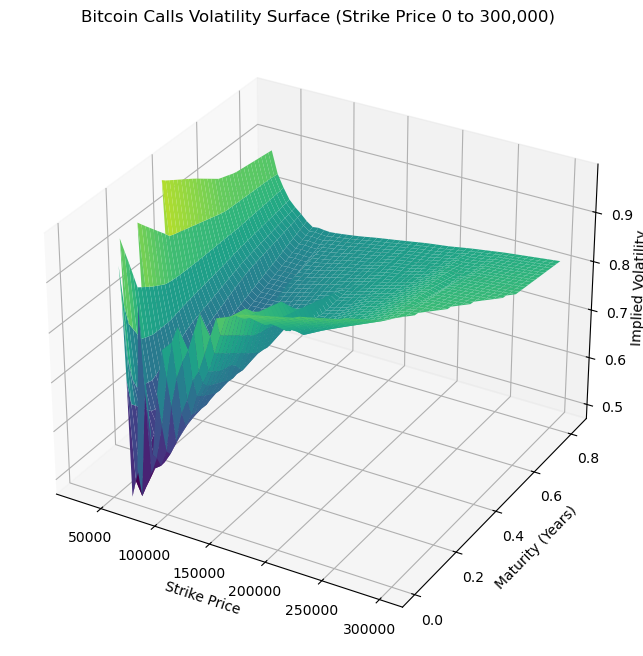

In [30]:
filtered_options_data_calls = options_data_calls[(options_data_calls['Implied Volatility'] >= 0) & (options_data['Implied Volatility'] <= 1)]

### COLUMNS FOR THE VOLATILITY SURFACE
strike_prices = filtered_options_data_calls['Strike']
maturities = filtered_options_data_calls['Time to Maturity (Years)']
implied_vols = filtered_options_data_calls['Implied Volatility']

### CREATING A GRID FOR STRIKES AND MATURITIES
strike_grid = np.linspace(strike_prices.min(), strike_prices.max(), 50)
maturity_grid = np.linspace(maturities.min(), maturities.max(), 50)
strike_grid, maturity_grid = np.meshgrid(strike_grid, maturity_grid)

### INTERPOLATING IMPLIED VOLATILITIES
vol_surface = griddata(
    (strike_prices, maturities),
    implied_vols,
    (strike_grid, maturity_grid),
    method='linear'  # Changed to 'linear'
)

### PLOTTING THE VOLATILITY SURFACE
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(strike_grid, maturity_grid, vol_surface, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Maturity (Years)')
ax.set_zlabel('Implied Volatility', labelpad = 0)
ax.set_title('Bitcoin Calls Volatility Surface (Strike Price 0 to 300,000)')

### Use the following code to adjust the viewing angle depending on results
### ax.view_init(elev=10, azim=60) ### Play with the numbers

plt.show()

C:\Users\xrist\AppData\Local\Temp\ipykernel_275632\2281243138.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_options_data_puts = options_data_puts[(options_data_puts['Implied Volatility'] >= 0) & (options_data['Implied Volatility'] <= 1)]


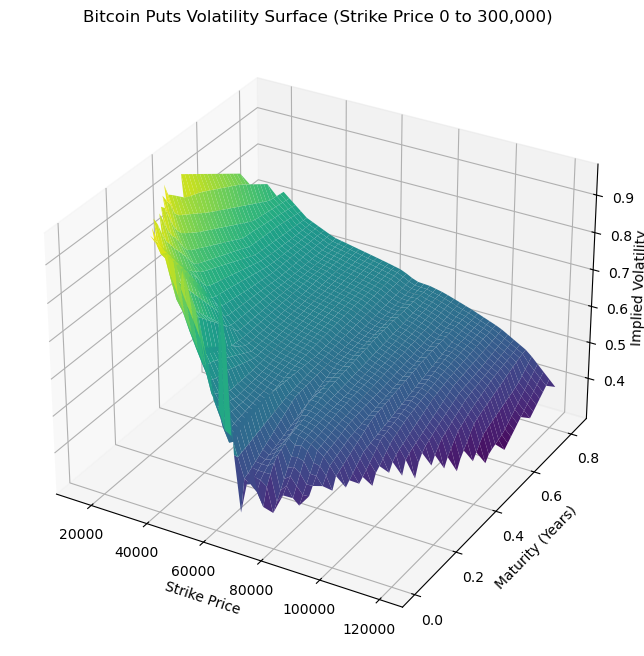

In [21]:
filtered_options_data_puts = options_data_puts[(options_data_puts['Implied Volatility'] >= 0) & (options_data['Implied Volatility'] <= 1)]

### COLUMNS FOR THE VOLATILITY SURFACE
strike_prices = filtered_options_data_puts['Strike']
maturities = filtered_options_data_puts['Time to Maturity (Years)']
implied_vols = filtered_options_data_puts['Implied Volatility']

### CREATING A GRID FOR STRIKES AND MATURITIES
strike_grid = np.linspace(strike_prices.min(), strike_prices.max(), 50)
maturity_grid = np.linspace(maturities.min(), maturities.max(), 50)
strike_grid, maturity_grid = np.meshgrid(strike_grid, maturity_grid)

### INTERPOLATING IMPLIED VOLATILITIES
vol_surface = griddata(
    (strike_prices, maturities),
    implied_vols,
    (strike_grid, maturity_grid),
    method='linear'  # Changed to 'linear'
)

### PLOTTING THE VOLATILITY SURFACE
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(strike_grid, maturity_grid, vol_surface, cmap='viridis')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Maturity (Years)')
ax.set_zlabel('Implied Volatility', labelpad=0)
ax.set_title('Bitcoin Puts Volatility Surface (Strike Price 0 to 300,000)')

### Use the following code to adjust the viewing angle depending on results
### ax.view_init(elev=10, azim=60) ### Play with the numbers

plt.show()

In [18]:
### MORE WORK IS IN THE MAKING 
### CHRISTOS STAMATELOPOULOS 30/05/2024